According to Matt's epxeriance ([link](https://github.com/goodarzilab/khorms/blob/master/side_projects/COVID_DMSseq_library.ipynb)) I'm using this genome:

- https://www.ncbi.nlm.nih.gov/nuccore/MN908947?%3Fdb=nucleotide


# Peaks
<img src="plots/igv_snapshot.png" style="height:400px">

# _N_
<img src="plots/N1.png" style="height:400px">
<img src="plots/N2.png" style="height:400px">
<img src="plots/N3.png" style="height:400px">

# _ORF10_
<img src="plots/orf10.png" style="height:400px">

# _S_
<img src="plots/S1.png" style="height:400px">
<img src="plots/S2.png" style="height:400px">


# Motif analysis 

In [645]:
%%bash 
cat exomepeak/virus/S0085/S0085/peak.bed exomepeak/virus/S0008/S0008/peak.bed \
exomepeak/virus/S0009/S0009/peak.bed exomepeak/virus/S0014/S0014/peak.bed \
exomepeak/virus/S0026/S0026/peak.bed exomepeak/virus/S0030/S0030/peak.bed | grep -v '^ *#' | bed12ToBed6 | \
sort -k1,1 -k2,2n | mergeBed -i - -c 4 -o distinct | awk '{print $1"\t"$2"\t"$3"\t"$4"\t"".""\t""+"}' > lowCt_peaks.bed

bedtools getfasta -name -s -fi virus/coronavirus_2_isolate_Wuhan-Hu-1.fasta -bed lowCt_peaks.bed -split -fo lowCt_peaks.fa

awk -F "\t" '{OFS=FS}{$4=$4"_peak"}; cnt[$4]++{$4=$4"_"cnt[$4]} 1' lowCt_peaks.bed > lowCt_peaks.c.bed

In [641]:
import re
import pandas as pd 

DRACH = re.compile('[AGT][AG]AC[ACT]') 
RGAC = re.compile('[AG]GAC') 
AAGAA = re.compile('AAGAA') 

def read_fasta(path):
    file = open(path)
    lines = file.read().splitlines()
    ids = [s[1:] for s in lines if '>' in s]
    n = [i for i,s in enumerate(lines) if '>' in s]
    n.append(len(lines))
    sequences = [''.join(lines[i+1:j]) for i,j in zip(n[:-1],n[1:])]
    file.close()
    fa = dict(zip(ids, sequences))
    return fa

def find_motifs(sam):
    motifs = [[f.split('::')[0], 
         len(DRACH.findall(sam[f])), 
         len(RGAC.findall(sam[f])), 
         len(AAGAA.findall(sam[f])),
         ','.join(DRACH.findall(sam[f]) + RGAC.findall(sam[f]) + AAGAA.findall(sam[f]))
             ]
        for n, f in enumerate(sam)
              
    ]
    
    df = pd.DataFrame(motifs, columns=["loci","DRACH", "RGAC", "AAGAA","Sequence"])
    
    return df


peaks = read_fasta('lowCt_peaks.fa')
df = find_motifs(peaks)
df.replace("", nan_value, inplace=True)

df.dropna(subset=["Sequence"])

,loci,DRACH,RGAC,AAGAA,Sequence
1,S,6,1,0,"GAACC,AGACT,TGACC,AAACA,AAACT,TAACT,AGAC"
11,S,1,0,0,GAACA
12,S,2,2,0,"AGACT,AGACT,AGAC,AGAC"
15,S,0,1,0,AGAC
17,ORF7a,0,0,1,AAGAA
19,ORF7a,1,0,0,TGACT
22,N,4,2,0,"GGACC,GGACC,TAACC,AAACA,GGAC,GGAC"
23,N,4,3,0,"AGACC,GGACA,TAACA,TGACC,AGAC,GGAC,AGAC"
24,N,6,2,1,"GAACT,GGACT,TAACA,TAACA,GAACA,GAACT,GGAC,AGAC,..."
26,N,1,0,0,TGACA


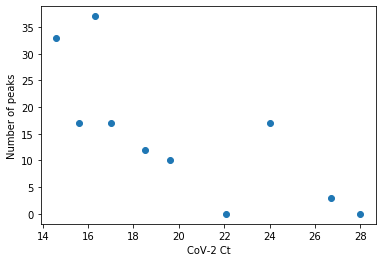

In [177]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

qPCR = pd.read_csv('RTqPCR.txt', sep='\t',index_col=0)
# create some x data and some integers for the y axis
x = np.array(qPCR.iloc[:,0])
y = np.array(qPCR.iloc[:,1], dtype=int)

# plot the data
# fig = plt.figure()
# plt.scatter(x, y)
# plt.xlabel('CoV-2 Ct', fontsize=10)
# plt.ylabel('Number of peaks', fontsize=10)
# fig.savefig('plots/Ct_vs_peak.pdf')
plt.scatter(x, y)
plt.xlabel('CoV-2 Ct', fontsize=10)
plt.ylabel('Number of peaks', fontsize=10)
plt.show()

## internal control 
m6A+ m6A- [N6-Methyladenosine Enrichment Kit](https://international.neb.com/-/media/nebus/files/manuals/manuale1610.pdf?rev=c064d5e232414f709ef8bccee56f7687&hash=AAA94B8FDA043DD5A610E14686552B5E0209EA94)

In [364]:
qPCR = pd.read_csv('RTqPCR.txt', sep='\t',index_col=0)

res = pd.read_csv('internal_control/result.txt', sep='\t')

pos  = [np.log2(res.loc[i+1,'pos']/res.loc[i,'pos']) for i in list(range(0,res.shape[0],2))]
neg  = [np.log2(res.loc[i+1,'neg']/res.loc[i,'neg']) for i in list(range(0,res.shape[0],2))]

Samples = [res.iloc[i,0].split('_')[0] for i in list(range(0,res.shape[0],2))]

log2res = pd.DataFrame(index=Samples)

qPCR['m6A_pos_ctrl'] = pos
qPCR['m6A_neg_ctrl'] = neg

qPCR


,CoV-2 Ct,Number of peaks,m6A_pos_ctrl,m6A_neg_ctrl
Sample,,,,
S0008,19.6,10,3.683781,-2.090802
S0009,18.5,12,6.804162,-0.219748
S0014,16.3,37,2.141356,-3.560361
S0017,24.0,17,1.651047,-7.253435
S0025,22.1,0,6.203816,-1.010379
S0026,15.6,17,8.585372,2.581687
S0030,17.0,17,8.069236,1.410737
S0042,28.0,0,4.671282,-0.919416
S0057,26.7,3,8.344047,-1.969256


# count peaks 

In [ ]:
%%bash 
for f in virus_bam/*bam; 
	do base=`basename $f`; 
	out=${base/.bam/.fc}; 
	bamToBed -i $f | intersectBed -split -s -wo -a - -b lowCt_peaks.c.bed | cut -f10 | sort | uniq -c | awk '{ print $2 "\t" $1}' > virus_count/$out; 
done 

In [651]:
import os
import pandas as pd

#list the files
filelist = os.listdir('virus_count')

#read them into pandas
df_list = [pd.read_csv('virus_count/' + file, header=None, sep='\t', index_col=0) for file in filelist]
#concatenate them together
big_df = pd.concat(df_list, axis=1)
big_df.columns = [f.split('.')[0] for f in filelist]

TotalRIP = big_df.filter(like='RIP').sum()
TotalIN  = big_df.filter(like='IN').sum()

Peak_names = big_df.index.tolist()
Samples = np.unique([f.split('_')[0] for f in filelist]).tolist()

res = list()
for s in Samples:    
    data = big_df.filter(like=s)
    res.append([s, np.log2 (
        (np.array(data.filter(like='RIP'), dtype=int)/ TotalRIP[s+'_RIP']) /
        (np.array(data.filter(like='IN'), dtype=int) / TotalIN[s+'_IN']))])
    

res_df = pd.DataFrame(data=np.concatenate([r[1] for r in res], axis=1), 
             columns=[r[0] for r in res],
             index=Peak_names)
res_df.to_csv('log2RIPvsIN.txt', sep='\t')

# Heatmap

In [720]:
%%bash 
for f in exomepeak/virus/*/*/peak.bed; do 
    o=${f/peak.bed/peak.c.bed}
    awk -F "\t" '{OFS=FS}{$4=$4"_peak"}; cnt[$4]++{$4=$4"_"cnt[$4]} 1' $f > $o
done 

In [870]:
# read bed files as df
for s in ['S0014','S0026','S0030','S0085']:
        peaks = pd.read_csv('exomepeak/virus/'+s+'/'+s+'/peak.c.bed', sep='\t')
        scores.append([s, peaks.score.tolist()])
        names.append( [s, peaks.name_peak.tolist()])
        all_peaks[s] = peaks

# extract scores by sample
all_peak_names = list()
for p in all_peaks: all_peak_names.extend(all_peaks[p].name_peak.tolist())

peak_by_sam_df = pd.DataFrame(index=np.unique(np.array(all_peak_names, dtype=str)))

for p in all_peaks: peak_by_sam_df.loc[all_peaks[p].name_peak.tolist(), p] = all_peaks[p].score.tolist()
    
# peak_by_sam_df < 0.005 

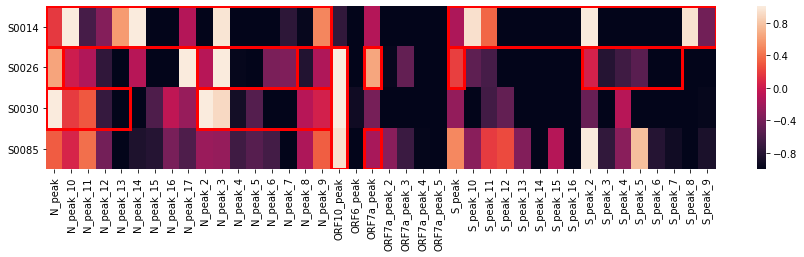

In [869]:
import seaborn as sns
from matplotlib.patches import Rectangle

plt.figure(figsize=(15,3))
heat_map = sns.heatmap(res_df[['S0014','S0026','S0030','S0085']].T, 
                       vmin=-1, vmax=1)


# ORF10
heat_map.add_patch(Rectangle((17, 1), 1, 3, fill=False, edgecolor='red', lw=3))

# S0014
heat_map.add_patch(Rectangle((0, 0), 17, 1, fill=False, edgecolor='red', lw=3))
heat_map.add_patch(Rectangle((24, 0), 16, 1, fill=False, edgecolor='red', lw=3))
# S0026
heat_map.add_patch(Rectangle((0, 1), 1, 1, fill=False, edgecolor='red', lw=3))
heat_map.add_patch(Rectangle((9, 1), 6, 1, fill=False, edgecolor='red', lw=3))
heat_map.add_patch(Rectangle((19, 1), 1, 1, fill=False, edgecolor='red', lw=3))
heat_map.add_patch(Rectangle((24, 1), 1, 1, fill=False, edgecolor='red', lw=3))
heat_map.add_patch(Rectangle((32, 1), 6, 1, fill=False, edgecolor='red', lw=3))

# S0030
heat_map.add_patch(Rectangle((0, 2), 5, 1, fill=False, edgecolor='red', lw=3))
heat_map.add_patch(Rectangle((9, 2), 8, 1, fill=False, edgecolor='red', lw=3))

# S0085
heat_map.add_patch(Rectangle((19, 3), 1, 1, fill=False, edgecolor='red', lw=3))

bottom, top = heat_map.get_ylim()
heat_map.set_ylim(bottom + 0.5, top - 0.5)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)

plt.show()

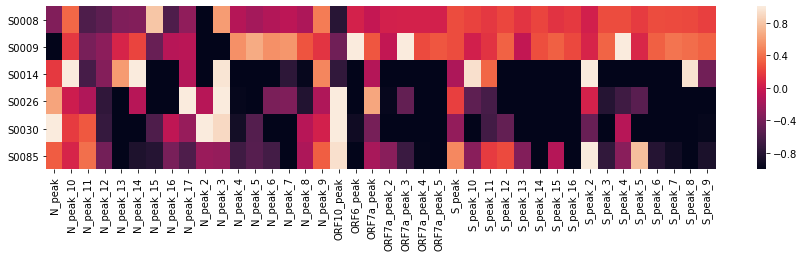

In [654]:
import seaborn as sns

plt.figure(figsize=(15,3))
heat_map = sns.heatmap(res_df[['S0008','S0009','S0014','S0026','S0030','S0085']].T, 
                       vmin=-1, vmax=1)


bottom, top = heat_map.get_ylim()
heat_map.set_ylim(bottom + 0.5, top - 0.5)


heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.show()

In [575]:
cat _sh/exompeak.virus.R


library(GenomicFeatures)
library(exomePeak)

args <- commandArgs(trailingOnly = TRUE)

jobID  <- args[1]
OUTPUT <- args[2]
Sample <- args[3]
INPUT <- args[4]
IP <- args[5]

GTF = '~/Projects/COVID19_m6A/virus/coronavirus_2_isolate_Wuhan-Hu-1.gff3'

######################################## read meta ######################################$


IP_BAM = paste(Sample, IP, '.bam', sep='')
INPUT_BAM = paste(Sample, INPUT, '.bam', sep='')

print (IP_BAM)
print (INPUT_BAM)
print (OUTPUT)
######################################## functions ######################################
txdb <- makeTxDbFromGFF(GTF, organism=NA )

setwd(jobID)
print (txdb)

run_exomepeak <- function(    WINDOW = 15, STEP = 5, LENGTH = 15, FDR = 0.025, ENRICH = 0.2){
    res <- exomepeak(
        TXDB = txdb,
        IP_BAM=IP_BAM,
        INPUT_BAM=INPUT_BAM,
        OUTPUT_DIR=OUTPUT,
        EXPERIMENT_NAME=Sample,
        # options
        WINDOW_WIDTH = WINDOW,
        SLIDING_STEP = STEP,
        FRAGMENT_LENGTH = LEN

In [650]:
cat _sh/pipeline.sh

###################### pre processing #############################
conda activate deseq 

mkdir -p trim
for fq in fastq/S00*R2*; do
    fq=`basename $fq`;
    out=${fq/_001.fastq.gz/.trim.fastq.gz};
    echo -------------------------$fq------------------------
    cutadapt -j 12 -u 3 -o trim/$out fastq/$fq
done

# map to human genome 
mkdir -p bam

STAR --genomeLoad LoadAndExit --genomeDir /rumi/shams/genomes/hg38/

for fq in fastq/*_R1*; do
    fq1=`basename $fq`;
    fq2=${fq1/R1_001.fastq.gz/R2.trim.fastq.gz};
    out=${fq1/R1_001.fastq.gz/};
    STAR \
    --outSAMtype BAM SortedByCoordinate \
    --readFilesCommand zcat \
    --runThreadN 16 \
    --genomeDir /rumi/shams/genomes/hg38/ \
    --readFilesIn fastq/$fq1 trim/$fq2 \
    --outFileNamePrefix bam/$out \
    --outReadsUnmapped Fastx;
done

STAR --genomeLoad Remove --genomeDir /rumi/shams/genomes/hg38/
rm Aligned.out.sam Log*out
rm -r bam/Undetermined_S0*

mkdir -p virus_fastq
mv bam/*_Unmapped.out.mate[1-2] virus_fastq/

m